# Import libraries

In [1]:
import numpy as np
import cv2
import glob
import cvxpy as cp
import scipy
import matplotlib.pyplot as plt

# Global Initializations

In [2]:
DATASET_FOLDER = "./theatre_dataset/"
VIDEO_FOLDER = "braunfels_1"
ASPECT_RATIO = 16/9
SHOT_SPECS = "MS 0,1" # Actor numbering starts from 0
ACTORS_TO_MONITOR = [int(i.strip()) for i in SHOT_SPECS[3:].split(",")]

# Multi-clip research paper

## Load files

In [3]:
file_video_input = cv2.VideoCapture(DATASET_FOLDER + VIDEO_FOLDER + "/" + VIDEO_FOLDER + ".mp4")
VIDEO_INPUT_CODEC = int(file_video_input.get(cv2.CAP_PROP_FOURCC)) # not working
VIDEO_INPUT_FRAME_SIZE = (int(file_video_input.get(cv2.CAP_PROP_FRAME_WIDTH)), int(file_video_input.get(cv2.CAP_PROP_FRAME_HEIGHT)))
VIDEO_INPUT_FPS = int(file_video_input.get(cv2.CAP_PROP_FPS))
VIDEO_INPUT_FRAMES_COUNT = int(file_video_input.get(cv2.CAP_PROP_FRAME_COUNT))
file_video_input.release()

In [4]:
VIDEO_INPUT_CODEC, VIDEO_INPUT_FRAME_SIZE, VIDEO_INPUT_FPS, VIDEO_INPUT_FRAMES_COUNT

(828601953, (3840, 2160), 29, 2278)

In [5]:
# This is the bounding box
bx1_t_orig = np.empty(shape = (VIDEO_INPUT_FRAMES_COUNT, 0), dtype = np.int16) # dimensions = frames count x no of actors
bx2_t_orig = np.empty(shape = (VIDEO_INPUT_FRAMES_COUNT, 0), dtype = np.int16) # dimensions = frames count x no of actors
by1_t_orig = np.empty(shape = (VIDEO_INPUT_FRAMES_COUNT, 0), dtype = np.int16) # dimensions = frames count x no of actors
by2_t_orig = np.empty(shape = (VIDEO_INPUT_FRAMES_COUNT, 0), dtype = np.int16) # dimensions = frames count x no of actors
for file_name in sorted(glob.glob(DATASET_FOLDER + VIDEO_FOLDER + "/tracks/*.txt")):
    np_temp_data = np.rint(np.loadtxt(file_name)).astype(np.int16)
    bx1_t_orig = np.append(bx1_t_orig, np_temp_data[:, [0]], axis = 1)
    bx2_t_orig = np.append(bx2_t_orig, np_temp_data[:, [2]], axis = 1)
    by1_t_orig = np.append(by1_t_orig, np_temp_data[:, [1]], axis = 1)
    by2_t_orig = np.append(by2_t_orig, np_temp_data[:, [3]], axis = 1)
bx1_t = bx1_t_orig[:, ACTORS_TO_MONITOR] # dimensions = frames count x no of actors to monitor
bx2_t = bx2_t_orig[:, ACTORS_TO_MONITOR] # dimensions = frames count x no of actors to monitor
by1_t = by1_t_orig[:, ACTORS_TO_MONITOR] # dimensions = frames count x no of actors to monitor
by2_t = by2_t_orig[:, ACTORS_TO_MONITOR] # dimensions = frames count x no of actors to monitor

# This is the inclusion region
xl_t = bx1_t.min(axis = 1) # inclusion region left coordinate # dimensions = frames count, 
xr_t = bx2_t.max(axis = 1) # inclusion region right coordinate # dimensions = frames count, 
yu_t = by1_t.min(axis = 1) # inclusion region up coordinate # dimensions = frames count, 
yb_t = yu_t + 2 * (by2_t.max(axis = 1) - yu_t) # inclusion region bottom coordinate # dimensions = frames count, 

x_t = (xl_t + xr_t)//2 # midpoint of inclusion region along horizontal direction # dimensions = frames count, 
y_t = (yu_t + yb_t)//2 # midpoint of inclusion region along vertical direction # dimensions = frames count, 
s_t = (yb_t - yu_t)//2 # half of the height of the inclusion region # dimensions = frames count, 

In [6]:
h_t = np.zeros(shape = bx1_t_orig.shape) # dimensions = frames count x no of actors
temp = (bx1_t_orig + bx2_t_orig) / 2 # mid point along X axis of all the actors
h_t[list(range(VIDEO_INPUT_FRAMES_COUNT)), temp.argmin(axis = 1)] = -1
h_t[list(range(VIDEO_INPUT_FRAMES_COUNT)), temp.argmax(axis = 1)] = 1
del temp

In [7]:
bx_t = (bx1_t + bx2_t) / 2 # center point of bounding box along X axis of all the actors to monitor # dimensions = frames count x no of actors to monitor
bx_t_dot = bx_t[1:] - bx_t[:-1] # research paper section 4.5
by_t = (by1_t + by2_t) / 2 # center point of bounding box along Y axis of all the actors to monitor # dimensions = frames count x no of actors to monitor
by_t_dot = by_t[1:] - by_t[:-1] # reseach paper section 4.5
bs_t = (by2_t - by1_t) / 2 # size of the bounding box of all the actors to monitor # dimensions = frames count x no of actors to monitor
bs_t_dot = bs_t[1:] - bs_t[:-1] # reseach paper section 4.5

In [8]:
c_t_threshold = 5
cx_t = 1 * np.logical_or(bx_t_dot <= c_t_threshold, bx_t_dot >= -c_t_threshold)
cy_t = 1 * np.logical_or(by_t_dot <= c_t_threshold, by_t_dot >= -c_t_threshold)
cs_t = 1 * np.logical_or(bs_t_dot <= c_t_threshold, bs_t_dot >= -c_t_threshold)

## Optimization

In [9]:
# variables
f_t = cp.Variable(shape = (VIDEO_INPUT_FRAMES_COUNT, 3)) # dimensions = frames count x no of variables for each frame (fx_t, fy_t and fs_t)

# 4.1: inclusion constraints
list_constraints = [1<=f_t[:,0]-ASPECT_RATIO*f_t[:,2], f_t[:,0]-ASPECT_RATIO*f_t[:,2]<=xl_t, f_t[:,0]+ASPECT_RATIO*f_t[:,2]<=VIDEO_INPUT_FRAME_SIZE[0], xr_t<=f_t[:,0]+ASPECT_RATIO*f_t[:,2]] # equation 1
list_constraints.extend([1 <= f_t[:, 1] - f_t[:, 2], f_t[:, 1] - f_t[:, 2] <= yu_t, f_t[:, 1] + f_t[:, 2] <= VIDEO_INPUT_FRAME_SIZE[1], yb_t <= f_t[:, 1] + f_t[:, 2]]) # equation 2

# 4.2: shot size penalty
temp = cp.Constant(0)
for actor_no in ACTORS_TO_MONITOR:
    temp += cp.square(f_t[:, 0] - x_t + 0.17 * ASPECT_RATIO * cp.multiply(f_t[:, 2], h_t[:, actor_no]))
d_epsilon = 0.5 * cp.sum(temp + cp.square(f_t[:, 1] - y_t) + cp.square(f_t[:, 2] - s_t))
del temp

# 4.3: first order L1-norm regularization
diag_matrix_1 = scipy.sparse.diags([-1, 1], offsets=[0, 1], shape=(VIDEO_INPUT_FRAMES_COUNT - 1, VIDEO_INPUT_FRAMES_COUNT))
l11_epsilon = cp.sum(cp.abs(diag_matrix_1 @ f_t))

# 4.4: third order L1-norm regularization
diag_matrix_2 = scipy.sparse.diags([-1, 3, -3, 1], offsets=[0, 1, 2, 3], shape=(VIDEO_INPUT_FRAMES_COUNT - 3, VIDEO_INPUT_FRAMES_COUNT))
l13_epsilon = cp.sum(cp.abs(diag_matrix_2 @ f_t))

# 4.5: apparant motion penalty
# Equation 6
diag_matrix_3 = scipy.sparse.diags([-1, 1], offsets=[0, 1], shape=(VIDEO_INPUT_FRAMES_COUNT - 1, VIDEO_INPUT_FRAMES_COUNT))
temp = cp.abs(diag_matrix_3 @ f_t)
m1_epsilon = cp.Constant(0)
for actor_no in range(cx_t.shape[1]):
    m1_epsilon += cp.sum(cp.multiply(cx_t[:, actor_no], temp[:, 0]) + cp.multiply(cy_t[:, actor_no], temp[:, 1]) + cp.multiply(cs_t[:, actor_no], temp[:, 2]))
del temp

# Equation 7
fx_t_dot = f_t[1:, 0] - f_t[:-1, 0]
fy_t_dot = f_t[1:, 1] - f_t[:-1, 1]
fs_t_dot = f_t[1:, 2] - f_t[:-1, 2]
m2_epsilon = cp.Constant(0)
for actor_no in range(cx_t.shape[1]):
    m2_epsilon += cp.sum(cp.maximum(np.zeros(shape = fx_t_dot.shape), -cp.multiply(bx_t_dot[:, actor_no] - fx_t_dot, bx_t_dot[:, actor_no])) + cp.maximum(np.zeros(shape = fx_t_dot.shape), -cp.multiply(by_t_dot[:, actor_no] - fy_t_dot, by_t_dot[:, actor_no])) + cp.maximum(np.zeros(shape = fx_t_dot.shape), -cp.multiply(bs_t_dot[:, actor_no] - fs_t_dot, bs_t_dot[:, actor_no])))

# 4.6: pull-in or keep-out penalty


# 4.7: Energy minimization
opt_problem = cp.Problem(cp.Minimize(d_epsilon + 500*l11_epsilon + 500*l13_epsilon + 500*m1_epsilon + 500*m2_epsilon), list_constraints)
opt_problem.solve(max_iter=50000)

# Final result
f_t = np.rint(f_t.value).astype(np.int16)

## Graphs

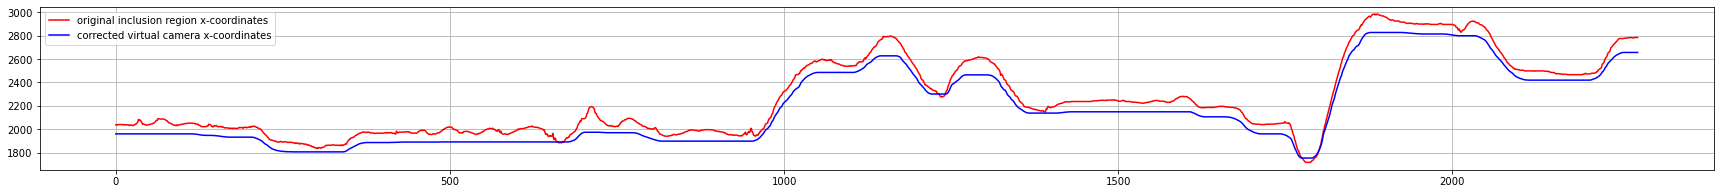

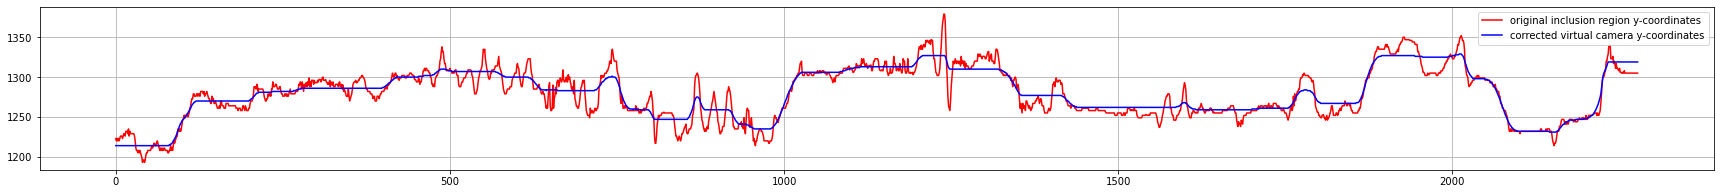

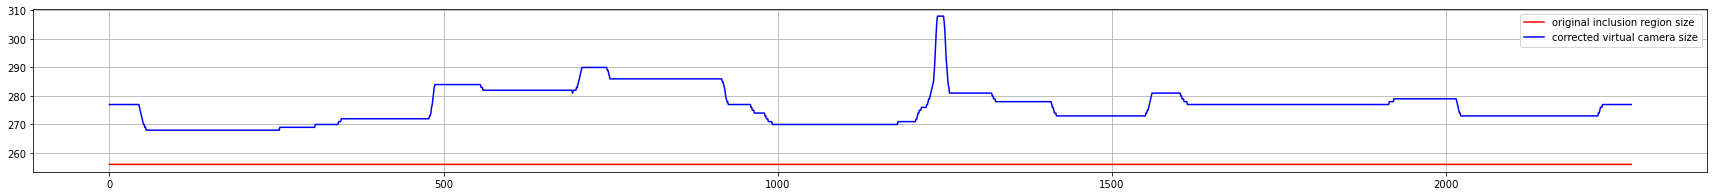

In [10]:
plt.rcParams["figure.figsize"] = (30,3)
plt.plot(range(VIDEO_INPUT_FRAMES_COUNT), x_t, 'r', label = "original inclusion region x-coordinates")
plt.plot(range(VIDEO_INPUT_FRAMES_COUNT), f_t[:, 0], 'b', label = "corrected virtual camera x-coordinates")
plt.grid()
plt.legend()
plt.show()
plt.plot(range(VIDEO_INPUT_FRAMES_COUNT), y_t, 'r', label = "original inclusion region y-coordinates")
plt.plot(range(VIDEO_INPUT_FRAMES_COUNT), f_t[:, 1], 'b', label = "corrected virtual camera y-coordinates")
plt.grid()
plt.legend()
plt.show()
plt.plot(range(VIDEO_INPUT_FRAMES_COUNT), s_t, 'r', label = "original inclusion region size")
plt.plot(range(VIDEO_INPUT_FRAMES_COUNT), f_t[:, 2], 'b', label = "corrected virtual camera size")
plt.grid()
plt.legend()
plt.show()

## Loop across the frames

In [11]:
temp_1 = np.rint(f_t[:, 0] - ASPECT_RATIO * f_t[:, 2]).astype(np.int16) # dimensions = frame count, 
temp_2 = np.rint(f_t[:, 0] + ASPECT_RATIO * f_t[:, 2]).astype(np.int16) # dimensions = frame count, 
# random_color = np.random.randint(256, size = 3).tolist()
# file_output_video = cv2.VideoWriter(DATASET_FOLDER + VIDEO_FOLDER + "/" + 'output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), VIDEO_INPUT_FPS, VIDEO_INPUT_FRAME_SIZE)
from pathlib import Path
Path(DATASET_FOLDER + VIDEO_FOLDER + "/" + SHOT_SPECS).mkdir(parents=True, exist_ok=True)
file_video_input = cv2.VideoCapture(DATASET_FOLDER + VIDEO_FOLDER + "/" + VIDEO_FOLDER + ".mp4")
for frame_no in range(VIDEO_INPUT_FRAMES_COUNT):
    success, img_frame = file_video_input.read() # frame read
    # img_frame_output = img_frame.copy() # copy the image
    cv2.imwrite(DATASET_FOLDER + VIDEO_FOLDER + "/" + SHOT_SPECS + "/{0:06d}.jpg".format(frame_no), img_frame[f_t[:, 1][frame_no] - f_t[:, 2][frame_no]: f_t[:, 1][frame_no] + f_t[:, 2][frame_no] + 1, temp_1[frame_no]: temp_2[frame_no]+1])
    # cv2.rectangle(img_frame_output, (temp_1[frame_no], f_t[:, 1][frame_no] - f_t[:, 2][frame_no]), (temp_2[frame_no], f_t[:, 1][frame_no] + f_t[:, 2][frame_no]), random_color, 1)
    # file_output_video.write(img_frame_output) # add frame to video
del temp_1, temp_2
# file_output_video.release()
file_video_input.release()